In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
%matplotlib qt


In [2]:
#read in calibration images and calibrate camera
images=glob.glob('camera_cal/calibration*.jpg')

#Arrays to store object points and image points from all the images
objpoints=[] #3D points in real world space 
imgpoints=[] #2D points in image plane

#Prepare object points like (0,0,0),(1,0,0),(2,0,0)...,(8,5,0)
objp=np.zeros((6*9,3),np.float32)

#Use Numnpy's mgrid function to generate the coordinates we want
#mgrid returns the coordintates values for a given grid size and they are shaped back into 2 columns, one for x and one for y
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)  #x,y coordinates

for fname in images:
    img=mpimg.imread(fname)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners=cv2.findChessboardCorners(gray,(9,6),None)
    
    #If corners are found, add object points, image points
    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        image=cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)


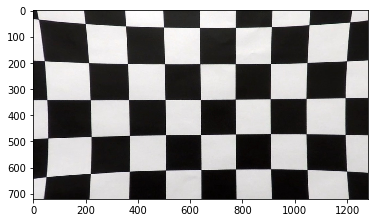

In [7]:
#undistort image
def cal_undist(img,mtx,dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return undist

# Load a test image, convert to RGB and undistort it
undist_cal_img = cv2.imread('camera_cal/calibration1.jpg')
undist_cal_img = cv2.cvtColor(undist_cal_img, cv2.COLOR_BGR2RGB)
undist_cal_img = cal_undist(cal_img, mtx, dist)

plt.imshow(undist_cal_img)

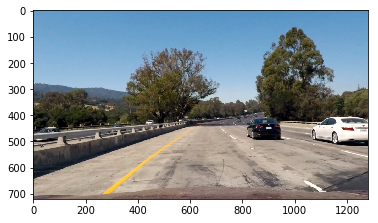

In [6]:
#undistort image
def cal_undist(img,mtx,dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return undist

# Load a test image, convert to RGB and undistort it
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cal_undist(img, mtx, dist)

plt.imshow(img)

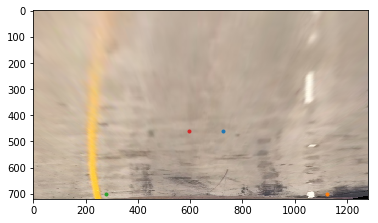

In [4]:
def warp(img, src, dst):
   
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
            
    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src, dst)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return Minv, warped



plt.plot(725, 460, '.')  #Top right
plt.plot(1125, 700, '.') #Bottom right
plt.plot(280, 700, '.')  #Bottom left
plt.plot(595, 460, '.')  #Top left

src=np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
dst=np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right  

Minv, warped_im=warp(img, src, dst)

plt.imshow(warped_im)



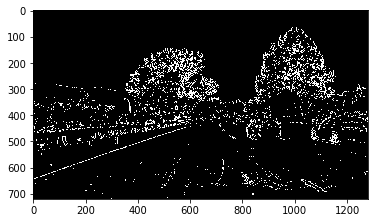

In [5]:
#define a function that applies Sobel x or y
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel=cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel=np.absolute(sobel)
    if orient == 'y':
        sobel=cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel=np.absolute(sobel)
    
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh_min) & (scaled_sobel<=thresh_max)]=1
    
    # 6) Return this mask as your binary_output image
    return binary_output

# Run the function for orient x
gradx = abs_sobel_thresh(img, orient='x',sobel_kernel=15, thresh_min=20, thresh_max=100)
plt.imshow(gradx, cmap='gray')

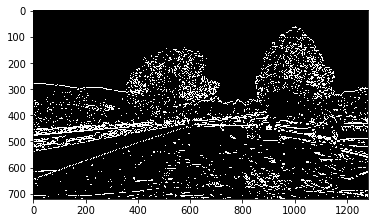

In [6]:
# Run the function for orient y
grady = abs_sobel_thresh(img, orient='y',sobel_kernel=15, thresh_min=20, thresh_max=100)
plt.imshow(grady, cmap='gray')

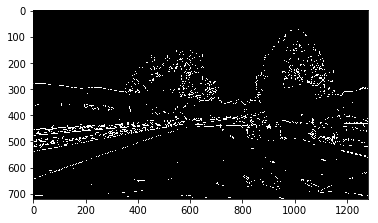

In [7]:
#Computes the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1,0)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0,1)
    # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt((sobelx**2)+(sobely**2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel=np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

# Run the function
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 100))
plt.imshow(mag_binary, cmap='gray')

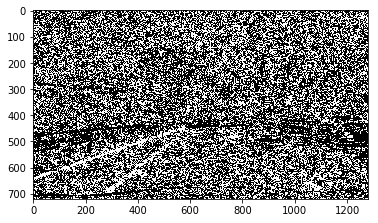

In [8]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F,0,1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir=np.arctan2(abs_sobely,abs_sobelx)
    #5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir>=thresh[0]) & (absgraddir<=thresh[1])]=1
    
    return binary_output
    
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary, cmap='gray')

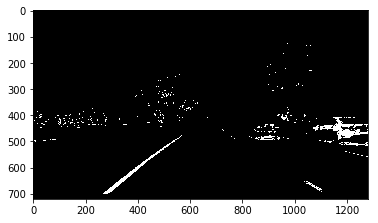

In [9]:
#function thresholds the S-channel of HLS 
def hls_select(img, thresh=(180, 255)):
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2] 
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

#Run the function
hls_binary = hls_select(img, thresh=(180, 255))
plt.imshow(hls_binary, cmap='gray')

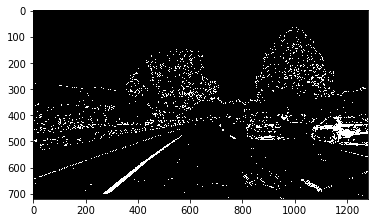

In [10]:
#Combine the selection thresholds
def combine_threshs(gradx, grady, mag_binary, dir_binary, hls_binary, ksize=15):
    
    # Combine the previous thresholds
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1

    return combined

#Run the function

combined = combine_threshs(gradx, grady, mag_binary, dir_binary, hls_binary, ksize=15)
plt.imshow(combined, cmap='gray')

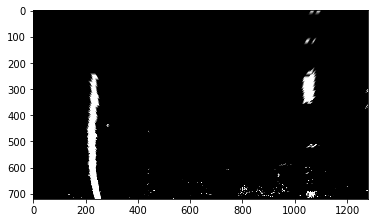

In [11]:
#Apply perspective transform to thresholded binary image
Minv,warped_combined = warp(combined, src, dst)
plt.imshow(warped_combined, cmap='gray')


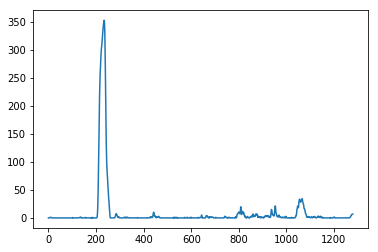

In [12]:
#plot histogram of where binary activation occur
def hist(img):
    
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(warped_combined)

# Visualize the resulting histogram
plt.plot(histogram)

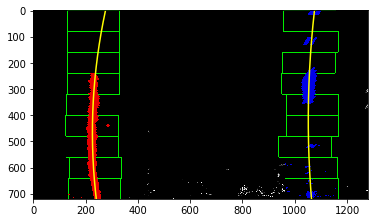

In [13]:
#Find the lines through sliding windows
def find_lane_pixels(img):
    
    # Take a histogram of the bottom half of the image
    histogram = hist(img)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

     # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current +margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,20,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,20,0), 2)
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) &(nonzerox>=win_xright_low) & (nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass   
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(img):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    
     ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    #Colors in the left and right lane regions
    out_img[lefty, leftx] = [25, 0, 0]
    out_img[righty, rightx] = [0, 0, 25]
    
    #Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

#Run the function
out_img=fit_polynomial(warped_combined)   
plt.imshow(out_img)    
    

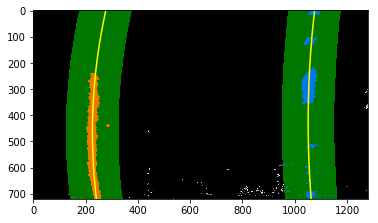

In [14]:

def fit_poly(img_shape, leftx, lefty, rightx, righty):
   
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(img):
    
    #Polynomils fit values from the previous frame
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox>(left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                      left_fit[2]-margin)) & (nonzerox<(left_fit[0]*(nonzeroy**2) +
                      left_fit[1]*nonzeroy + left_fit[2]+margin)))
    right_lane_inds = ((nonzerox>(right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                      right_fit[2] -margin)) & (nonzerox<(right_fit[0]*(nonzeroy**2) +
                      right_fit[1]*nonzeroy +right_fit[2] +margin))) 
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [25, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 25]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,25, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,25, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result


# Run image through the pipeline
left_fitx, right_fitx, ploty, result = search_around_poly(warped_combined)

# View your output
plt.imshow(result)

In [15]:

def measure_curvature_pixels(img):
    
    img_shape=img.shape
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    #Polynomils fit values from the previous frame
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval +left_fit[1])**2)**(3/2))/(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad =((1+(2*right_fit[0]*y_eval +right_fit[1])**2)**(3/2))/(2*right_fit[0])   ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad
    
    
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(warped_combined)

print(left_curverad, right_curverad)


2218.33229853 3750.00178972


In [16]:
def measure_curvature_real(img):
    
    img_shape=img.shape
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    #Polynomils fit values from the previous frame
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
          
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*(y_eval*ym_per_pix) +left_fit_cr[1])**2)**(3/2))/(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad =((1+(2*right_fit_cr[0]*(y_eval*ym_per_pix) +right_fit_cr[1])**2)**(3/2))/(2*right_fit_cr[0])   ## Implement the calculation of the right line here
       
    return left_curverad, right_curverad
    
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_real(warped_combined)

print(left_curverad, right_curverad)


714.27270377 1219.90156217


In [17]:
def lane_center_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

# Run the function
offsetx = lane_center_offset(left_fitx, right_fitx, img.shape)

print ('Offset of lane from center:', offsetx, 'm.')

Offset of lane from center: -0.0558745154042 m.


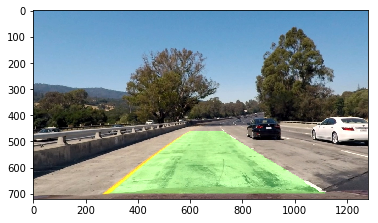

In [34]:
def drawing(img, warped_combined, left_fitx, right_fitx, ploty, Minv):

    # Create an image to draw the lines on    
    warp_zero = np.zeros_like(warped_combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result

# Run the function
img_lane = drawing(img, warped_combined, left_fitx, right_fitx, ploty, Minv)

plt.imshow(img_lane)

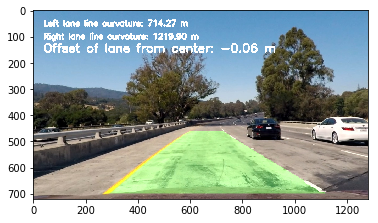

In [46]:
def display_info(img, warped_combined, left_fitx, right_fitx):
    
    output_img = img.copy()
    
    # Calculate car offset
    offsetx = lane_center_offset(left_fitx, right_fitx, output_img.shape)
    
    # Display car offset
    cv2.putText(output_img, 'Offset of lane from center: {:.2f} m'.format(offsetx), 
                (40, 160), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 5)
    
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad = measure_curvature_real(warped_combined)
    
    # Display lane curvature
    cv2.putText(output_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad),(40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 5)
    cv2.putText(output_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad),(40, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 5)
 
    return output_img

# Run the function
out_img = display_info(img_lane, warped_combined, left_fitx, right_fitx)
plt.imshow(out_img)
    

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
def process_image (img):
    
    img=cal_undist(img,mtx,dist)
    
    gradx = abs_sobel_thresh(img, orient='x',sobel_kernel=15, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y',sobel_kernel=15, thresh_min=20, thresh_max=100)
    
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 100))
    
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    hls_binary = hls_select(img, thresh=(180, 255))
    
    combined = combine_threshs(gradx, grady, mag_binary, dir_binary, hls_binary, ksize=15)
    
    src=np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    dst=np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right  
    
    #img=warp(img, src, dst)
    
    Minv,warped_combined = warp(combined, src, dst)
    
    #histogram = hist(warped_combined)
    
    out_img=fit_polynomial(warped_combined)
    
    left_fitx, right_fitx, ploty, result = search_around_poly(warped_combined)
    
    left_curverad, right_curverad = measure_curvature_pixels(warped_combined)
    
    left_curverad, right_curverad = measure_curvature_real(warped_combined)
    
    img_lane = drawing(img, warped_combined, left_fitx, right_fitx, ploty, Minv)
    
    output_img=display_info(img_lane, warped_combined, left_fitx, right_fitx)
    
    return output_img

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [12:22<00:00,  1.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 27s, sys: 46 s, total: 10min 13s
Wall time: 12min 25s


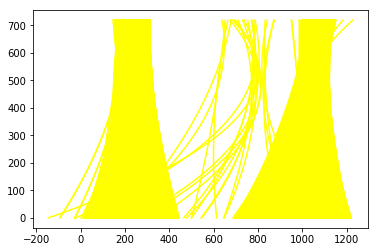

In [44]:
yellow_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))